In [1]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer

In [2]:
df=pd.read_csv("train_identity.csv").merge(pd.read_csv("train_transaction.csv"), how="right", left_on= "TransactionID", right_on= "TransactionID")

In [3]:
import pickle
with open('features_importantes', 'rb') as file:
    features_importantes = pickle.load(file)

In [4]:
los_20_mas_importantes_part_2= features_importantes.sort_values("importancia").nlargest(20, "importancia")

In [5]:
los_20_mas_importantes_part_2.index = los_20_mas_importantes_part_2.index.map(lambda x: df.columns[x]) 

In [6]:
del df["TransactionID"]

In [7]:
columnas_obligatorias = ["DeviceInfo", "TransactionDT", "isFraud", "id_31", "id_33", "DeviceType"]
columnas=[]
for c in features_importantes.index:
    columnas.append(df.columns[c])
for c in columnas_obligatorias:
    if not c in columnas:
        columnas.append(c)

In [8]:
df=df.filter(columnas)

In [9]:
for c in df.columns:
    if df[c].dtype==object: 
        df[c] = df[c].replace(np.nan, "NaN")
    else:
        df[c] = df[c].replace(np.nan, df[c].mean())

In [10]:
division_tran_validation = int(df["TransactionDT"][len(df)-1]*0.80)

In [11]:
df_train = df[df["TransactionDT"] <= division_tran_validation]
df_train_y = df_train["isFraud"]
df_validation = df[df["TransactionDT"] > division_tran_validation]
df_validation_y = df_validation["isFraud"]

In [12]:
%reset_selective -f "^df$"

In [13]:
lista_de_diccs = {}
one_hot_features = []
for c in df_train.columns:
    vectorizer = CountVectorizer()
    if df_train[c].dtype==object: 
        if len((df_train[c]).unique()) <= 10:
            one_hot = pd.DataFrame(vectorizer.fit_transform(df_train[c]).toarray()).rename(lambda x: c+sorted(vectorizer.vocabulary_ )[x], axis="columns")
            del df_train[c]
            one_hot_features.append(c)
            df_train = df_train.join(one_hot)
        else:
            dict_actual=df_train.groupby([c])['isFraud'].mean().to_dict()
            lista_de_diccs[c]=dict_actual
            df_train[c]=df_train[c].map(dict_actual)

In [14]:
del df_train["isFraud"]
del df_validation["isFraud"]

## Modelo 1 XGBOOST

In [15]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [16]:
hiperparametros = {}
hiperparametros["learning_rate"] = [0.1, 0.2, 0.3]
hiperparametros["colsample_bytree"] = np.arange(0.1, 0.5, 0.1)
hiperparametros["n_estimators"] = range(100,201, 10)
hiperparametros["max_depth"] = range(5, 11)
hiperparametros["subsample"]= np.arange(0.1, 0.5, 0.1)
hiperparametros["objective"]=["reg:squarederror", "reg:logistic"]

In [17]:
searcher = RandomizedSearchCV(xg_reg, hiperparametros,cv=3, random_state=1, n_iter=30, n_jobs=1)

In [18]:
searcher.fit(df_train, df_train_y)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(alpha=10, base_score=None,
                                          booster=None, colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.3,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1,
                                          max_delta_step=None, max_depth=5,
                                          min_child_weight=None, missing=nan,
                                          monotone_constrai...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validat

In [19]:
for c in one_hot_features:
    one_hot = pd.DataFrame(vectorizer.transform(df_validation[c]).toarray()).rename(lambda x: c+sorted(vectorizer.vocabulary_ )[x], axis="columns").set_index(df_validation.index)
    df_validation = df_validation.join(one_hot)
    del df_validation[c]
for c in df_validation.columns:
    if df_validation[c].dtype==object: 
        df_validation[c]= df_validation[c].map(lista_de_diccs[c])

In [20]:
roc_auc_score(df_train_y, searcher.best_estimator_.predict(df_train))

0.8580330099470383

In [21]:
roc_auc_score(df_validation_y, searcher.best_estimator_.predict(df_validation))

0.8086516989702566

In [22]:
df_test = pd.read_csv("test_identity.csv").merge(pd.read_csv("test_transaction.csv"), how="right", left_on= "TransactionID", right_on= "TransactionID")

In [23]:
transactionid = df_test["TransactionID"]
for c in df_test.columns:
    df_test.rename(columns={c: c.replace("id-", "id_")}, inplace=True)

In [24]:
df_test=df_test.filter(columnas)

In [25]:
for c in df_test.columns:
    if df_test[c].dtype==object: 
        df_test[c] = df_test[c].replace(np.nan, "NaN")
    else:
        df_test[c] = df_test[c].replace(np.nan, 0)

In [26]:
for c in one_hot_features:
    one_hot = pd.DataFrame(vectorizer.fit_transform(df_test[c]).toarray()).rename(lambda x: c+sorted(vectorizer.vocabulary_ )[x], axis="columns")
    del df_test[c]
    df_test = df_test.join(one_hot)
for c in df_test.columns:
    if df_test[c].dtype==object: 
        df_test[c]= df_test[c].map(lista_de_diccs[c])

In [27]:
pd.DataFrame({"TransactionID":transactionid, "isFraud":list(searcher.best_estimator_.predict(df_test))}).set_index("TransactionID").to_csv("df_entrega_concurso_xgb.csv")

## Puntuacion Final del concurso para XGBOOST
### 0.814913

## Modelo 2 RandomForest

In [28]:
rf_model = RandomForestRegressor(random_state=69)

In [29]:
hiperparametros = {}
hiperparametros["max_features"] = range(3,11)
hiperparametros["min_samples_split"] = range(5, 11)
hiperparametros["min_samples_leaf"] =range(5, 11)
hiperparametros["max_depth"] = range(5, 11)
hiperparametros["n_estimators"] = range(100,201, 10)

In [30]:
%reset_selective -f "^searcher$"
searcher = RandomizedSearchCV(rf_model, hiperparametros,cv=3, random_state=69, n_iter=20, n_jobs=2)

In [31]:
searcher.fit(df_train, df_train_y)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=69),
                   n_iter=20, n_jobs=2,
                   param_distributions={'max_depth': range(5, 11),
                                        'max_features': range(3, 11),
                                        'min_samples_leaf': range(5, 11),
                                        'min_samples_split': range(5, 11),
                                        'n_estimators': range(100, 201, 10)},
                   random_state=69)

In [32]:
for c in df_validation.columns:
    df_validation[c] = df_validation[c].replace(np.nan, 0)

In [33]:
roc_auc_score(df_validation_y, searcher.best_estimator_.predict(df_validation))

0.8161674703731933

In [34]:
for c in df_test.columns:
    df_test[c] = df_test[c].replace(np.nan, 0)

In [35]:
pd.DataFrame({"TransactionID":transactionid, "isFraud":list(searcher.best_estimator_.predict(df_test))}).set_index("TransactionID").to_csv("df_entrega_concurso_randomforet.csv")

## Puntuacion Final del concurso para RandomForestRegressor
### 0.844390

# Punto extra
## Graficar la importancia de features para algún modelo de la parte III. ¿Qué tanto se parece a los features importantes de la parte II? (1 punto) (Se grafico el model RandomForrest)

In [36]:
import matplotlib.pyplot as plt

In [43]:
df_importancia = pd.DataFrame(searcher.best_estimator_.feature_importances_).rename(columns={0:"importancia"})

In [46]:
df_importancia.index = df_importancia.index.map(lambda x: df_train.columns[x])

In [49]:
df_importancia=df_importancia.nlargest(20, "importancia")

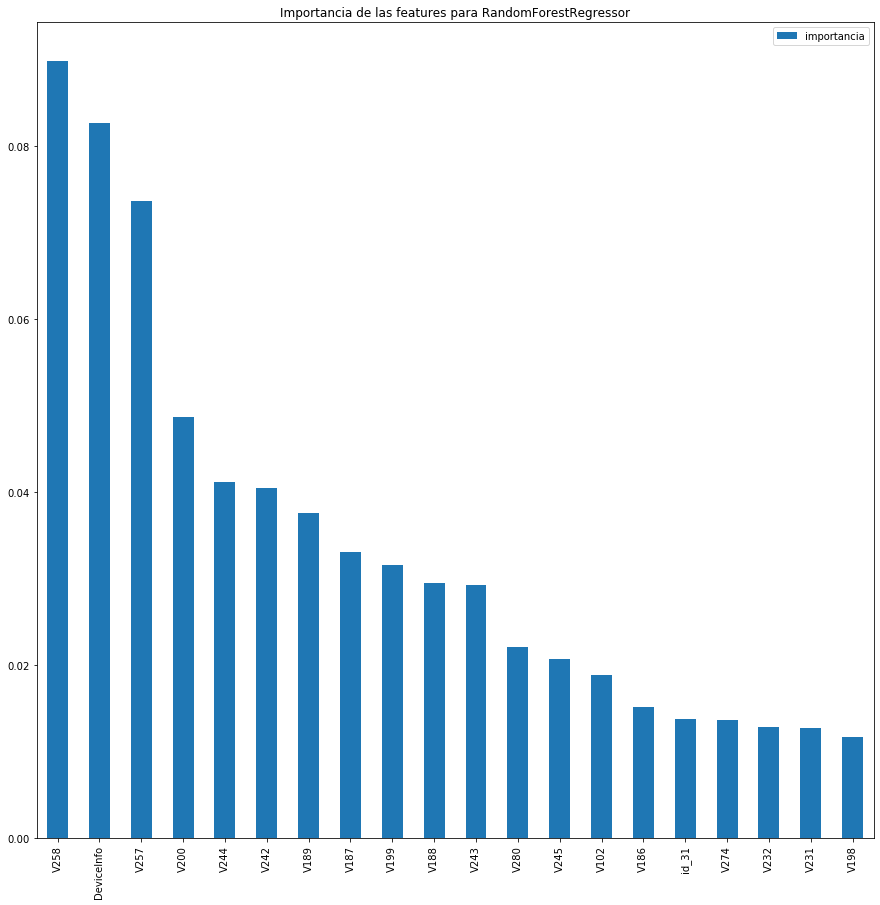

In [52]:
df_importancia.plot.bar(figsize=(15,15), title="Importancia de las features para RandomForestRegressor")

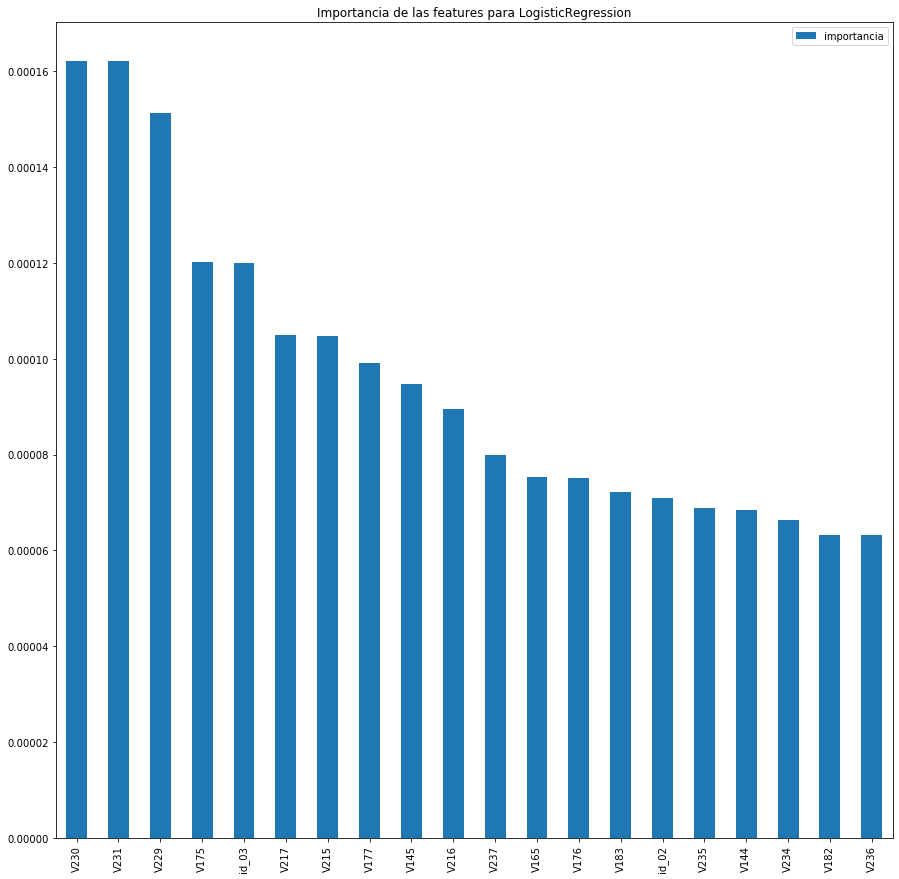

In [53]:
los_20_mas_importantes_part_2.plot.bar(figsize=(15,15),title="Importancia de las features para LogisticRegression")